# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

np.random.seed(619)  # Para mayor determinismo

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

dataset['TARGET'] = pd.Categorical(dataset.TARGET)

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

Antes de proseguir, echemos un vistazo a los datos

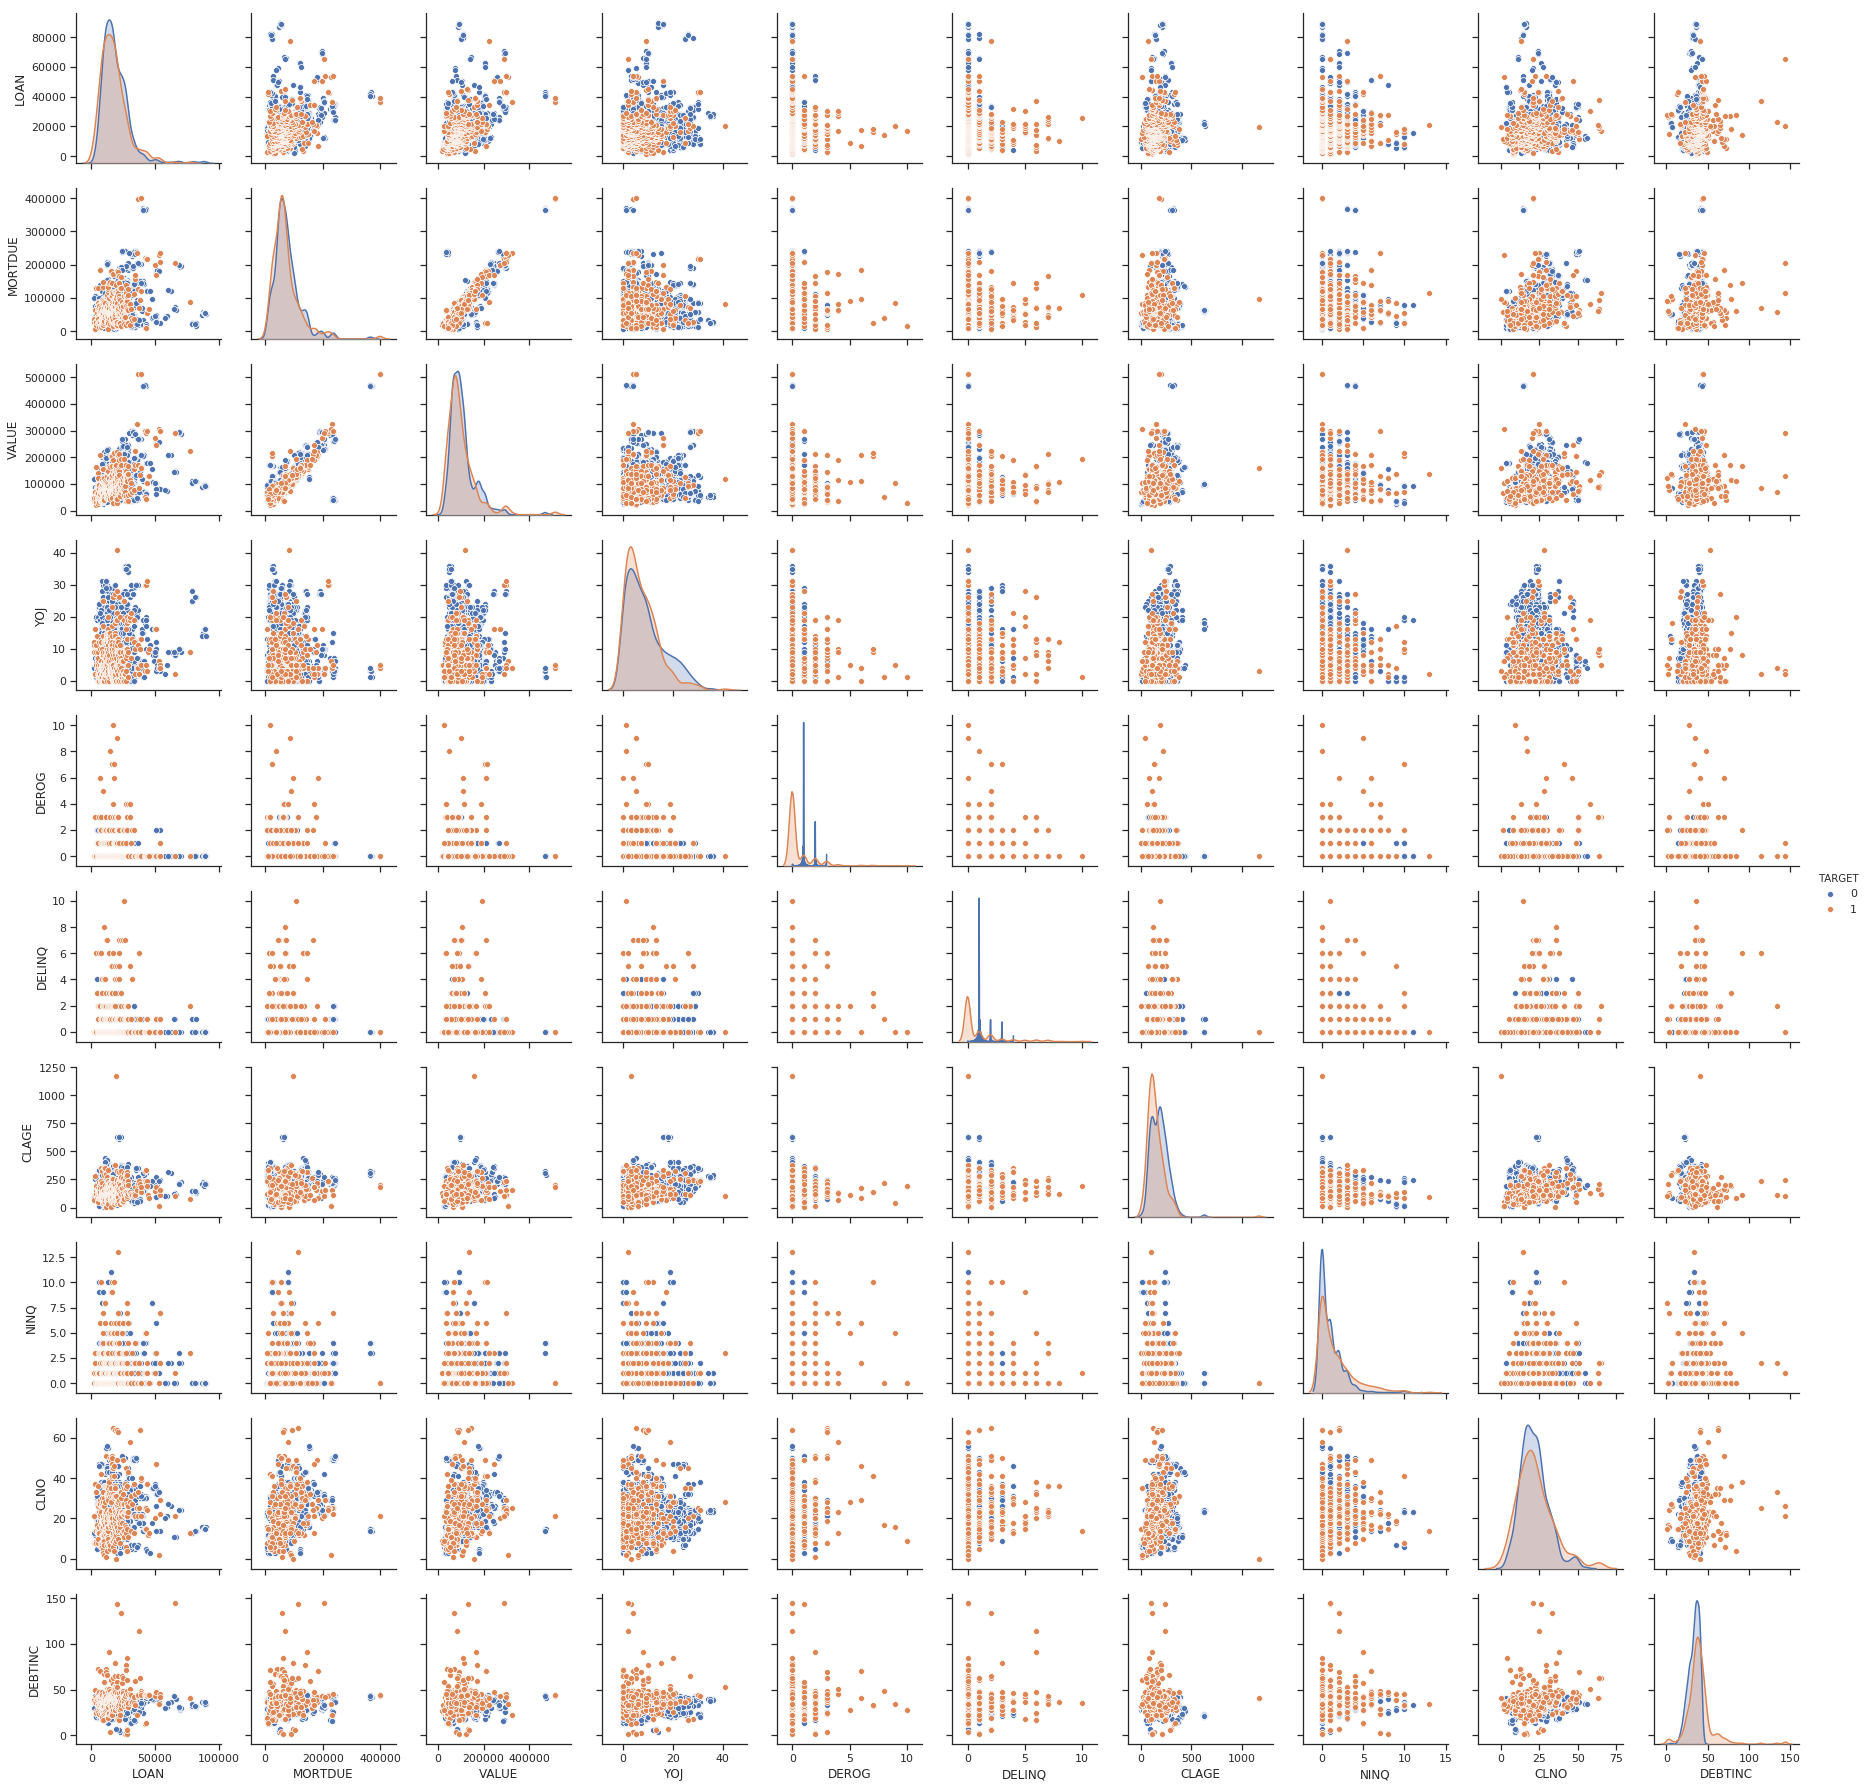

In [4]:
sns.set(style="ticks")
sns.pairplot(dataset,vars=dataset.columns[1:], hue="TARGET")

Primeramente, normalizaremos los datos

In [5]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
print("media: ",X_scaled.mean(axis=0))
print("std: ",X_scaled.std(axis=0))

media:  [-4.28759269e-17 -1.45634433e-16 -2.58692744e-17  3.64086084e-17
  7.66497018e-17 -4.59898211e-17 -1.83959284e-16  7.66497018e-17
  1.16890795e-16  1.83959284e-16]
std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

Check for imbalance

In [8]:
counts = np.bincount(y)
print("Imbalance %f" % (counts[1]/counts[0]))

Imbalance 0.200000


Como hay un 80% de imbalance en los datos, creamos dos conjuntos de datos nuevos: uno, submuestreando el original y el otro, sobremuestreando el subconjunto que tiene menos datos.

In [9]:
from collections import Counter
print(sorted(Counter(y).items()))

from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
print(sorted(Counter(y_resampled).items()))

[(0, 1545), (1, 309)]
[(0, 309), (1, 309)]


Using TensorFlow backend.


In [10]:
# división entre entrenamiento y evaluación
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=617)

In [11]:
print(sorted(Counter(y).items()))

from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
print(sorted(Counter(y_resampled).items()))

[(0, 1545), (1, 309)]
[(0, 1545), (1, 1545)]


In [12]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=617)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?

        Los datos se refieren a rendimientos de préstamos hipotecarios.


2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

        La variable objetivo que se quiere predecir es una variable binaria que dice si el tomador del préstamos dejó de cumplir con los pagos o está en mora. Si tiene valor 1 significa que el cliente entró en mora, mientras que si tiene valor 0 quiere decir que el cliente canceló el préstamo.


3. ¿Qué información (atributos) hay disponible para hacer la predicción?
    
        LOAN    : Monto del préstamo solicitado
        MORTDUE : Monto adeudado en la hipoteca existente
        VALUE   : Valor de la propiedad
        YOJ     : Antigüedad en el trabajo actual
        DEROG   : Número de informes despectivos
        DELINQ  : Número de lineas de crédito morosas
        CLAGE   : Edad de la líneal comercial más antigua en meses
        NINQ    : Número de líneas de crédito reciente
        CLNO    : Número de líneas de crédito
        DEBTINC : Relación deuda-ingresos

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

        LOAN, MORTDUE, DEBTINC


**No hace falta escribir código para responder estas preguntas.**

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [13]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if ax == None:
        fig, ax = plt.subplots()
        
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [15]:
clasificador = linear_model.SGDClassifier(random_state=617,max_iter=1000,tol=1e-3)
clasificador.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=617, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
y_true, y_pred = y_test, clasificador.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

              precision    recall  f1-score   support

           0       0.88      0.99      0.94       313
           1       0.89      0.29      0.44        58

   micro avg       0.88      0.88      0.88       371
   macro avg       0.89      0.64      0.69       371
weighted avg       0.89      0.88      0.86       371




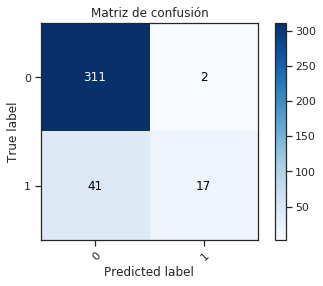

In [17]:
plot_confusion_matrix(y_true, y_pred,classes=dataset.TARGET.unique(), title="Matriz de confusión" )

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Exploración de hiperparámetros para función de coste "hinge"

Mejor conjunto de parámetros:
{'alpha': 1e-05, 'eta0': 0.01, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.799 (+/- 4.008e-03) para los parámetros {'alpha': 10.0, 'eta0': 10.0, 'learning_rate': 'constant'}
Exactitud: 0.821 (+/- 4.045e-04) para los parámetros {'alpha': 10.0, 'eta0': 1.0, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.0001, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 1e-05, 'learning_rate': 'constant'}
Exactitud: 0.799 (+/- 4.008e-03) pa

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.698 (+/- 7.023e-02) para los parámetros {'alpha': 10.0, 'eta0': 10.0, 'learning_rate': 'constant'}
Exactitud: 0.803 (+/- 2.620e-03) para los parámetros {'alpha': 10.0, 'eta0': 1.0, 'learning_rate': 'constant'}
Exactitud: 0.837 (+/- 1.878e-04) para los parámetros {'alpha': 10.0, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 0.0001, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 10.0, 'eta0': 1e-05, 'learning_rate': 'constant'}
Exactitud: 0.698 (+/- 7.023e-02) para

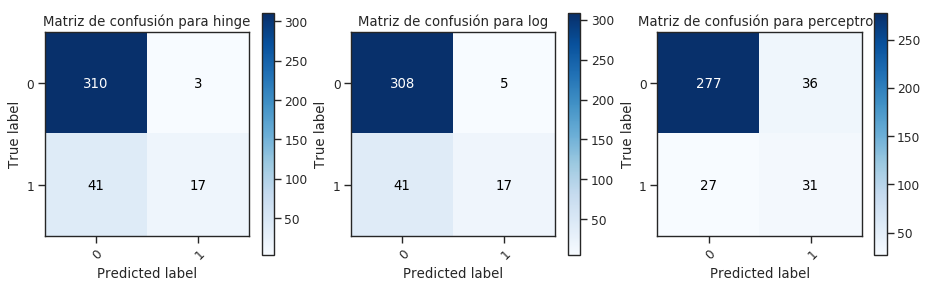

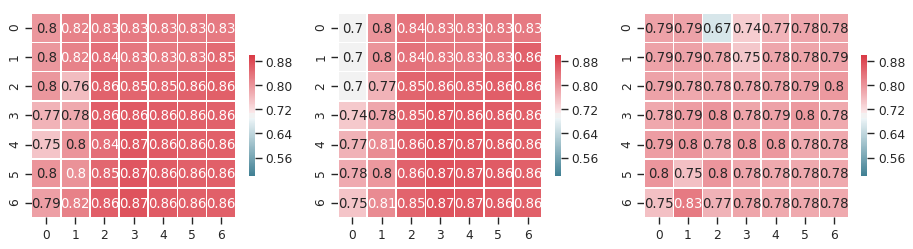

In [21]:
f1, ax1 = plt.subplots(1,3,figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
f2, ax2 = plt.subplots(1,3,figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

eta0 = np.logspace(1,-5,7)
alpha = np.logspace(1,-5,7)
learning_rate = 'constant'

for idx, loss in enumerate(('hinge','log','perceptron'), start=0):
    exploring_params = {
        'learning_rate': [learning_rate],
        'eta0': eta0,  # Tasa de entrenamiento
        'alpha': alpha  # Tasa de regularización
    }
    m = linear_model.SGDClassifier(random_state=617,loss=loss,tol=1e-3)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    accu = np.zeros(len(eta0)*len(alpha),dtype=np.float)
    _x = np.zeros(len(eta0)*len(alpha),dtype=np.float)
    _y = np.zeros(len(eta0)*len(alpha),dtype=np.float)
    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for i, (mean, std, params) in enumerate(zip(means,stds,model.cv_results_['params'])):
        _x[i] = params['alpha']
        _y[i] = params['eta0']
        accu[i] = means[i]
        print("Exactitud: %0.3f (+/- %0.03e) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")

    plot_confusion_matrix(y_true, y_pred,classes=dataset.TARGET.unique(), 
                          ax=ax1[idx],title="Matriz de confusión para %s" % loss)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    accu = accu.reshape((len(eta0),len(alpha)))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(accu,ax=ax2[idx],cmap=cmap,annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=0.5,vmax=0.9)
    
    

In [24]:
eta0 = np.logspace(1,-1,50)
alpha = np.logspace(-3,-6,50)

param_grid = {
    #'loss': ['hinge','log','modified_huber','squared_hinge','perceptron'], #función de loss
    #'loss': ['hinge','log','perceptron'], #función de loss
    'loss': ['perceptron'], #función de loss
    #'learning_rate': ['constant'],
    'learning_rate': ['constant'],
    'eta0': eta0,  # Tasa de entrenamiento
    'alpha': alpha  # Tasa de regularización
}

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mejor conjunto de parámetros:
{'alpha': 1.0985411419875572e-05, 'eta0': 0.8685113737513529, 'learning_rate': 'constant', 'loss': 'perceptron'}

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       313
           1       0.49      0.47      0.48        58

   micro avg       0.84      0.84      0.84       371
   macro avg       0.70      0.69      0.69       371
weighted avg       0.84      0.84      0.84       371





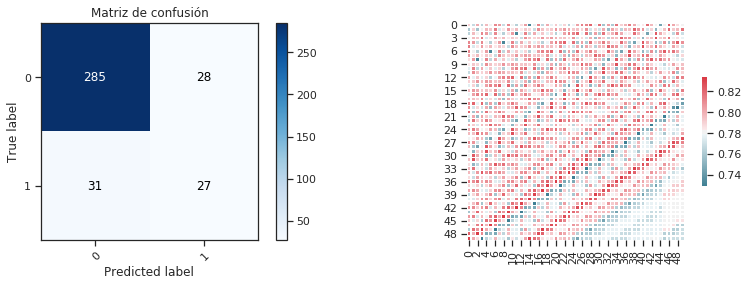

In [25]:
m = linear_model.SGDClassifier(random_state=617,tol=1e-3)
model = GridSearchCV(m, param_grid, cv=5, scoring='accuracy',n_jobs=4)
model.fit(X_train, y_train)
    
print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

#print("Puntajes de la grilla:", end="\n\n")
#means = model.cv_results_['mean_test_score']
#stds = model.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, model.cv_results_['params']):
#    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
#print()

accu = np.zeros(len(eta0)*len(alpha),dtype=np.float)
_x = np.zeros(len(eta0)*len(alpha),dtype=np.float)
_y = np.zeros(len(eta0)*len(alpha),dtype=np.float)
means = model.cv_results_['mean_test_score']
for i, params in enumerate(model.cv_results_['params']):
    _x[i] = params['alpha']
    _y[i] = params['eta0']
    accu[i] = means[i]
    

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")
print("================================================", end="\n\n")

f, ax = plt.subplots(1,2,figsize=(14,4))

plot_confusion_matrix(y_true, y_pred,classes=dataset.TARGET.unique(),ax=ax[0], title="Matriz de confusión" )


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

accu = accu.reshape((len(eta0),len(alpha)))
    
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(accu,cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax[1])

# Exploración de hiperparámetros para función de coste "hinge"

Mejor conjunto de parámetros:
{'alpha': 0.0047508101621027985}

Puntajes de la grilla:

Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 1.0}
Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 0.8902150854450386}
Exactitud: 0.831 (+/- 3.218e-06) para los parámetros {'alpha': 0.7924828983539173}
Exactitud: 0.833 (+/- 1.109e-05) para los parámetros {'alpha': 0.7054802310718643}
Exactitud: 0.833 (+/- 7.625e-06) para los parámetros {'alpha': 0.6280291441834253}
Exactitud: 0.835 (+/- 1.520e-05) para los parámetros {'alpha': 0.5590810182512224}
Exactitud: 0.837 (+/- 1.386e-05) para los parámetros {'alpha': 0.4977023564332111}
Exactitud: 0.837 (+/- 1.386e-05) para los parámetros {'alpha': 0.44306214575838804}
Exactitud: 0.840 (+/- 9.963e-06) para los parámetros {'alpha': 0.39442060594376555}
Exactitud: 0.842 (+/- 1.092e-05) para los parámetros {'alpha': 0.35111917342151316}
Exactitud: 0.843 (+/- 5.157e-0

# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.00210490414451202}

Puntajes de la grilla:

Exactitud: 0.831 (+/- 9.463e-07) para los parámetros {'alpha': 1.0}
Exactitud: 0.832 (+/- 5.340e-06) para los parámetros {'alpha': 0.8902150854450386}
Exactitud: 0.833 (+/- 6.881e-06) para los parámetros {'alpha': 0.7924828983539173}
Exactitud: 0.833 (+/- 6.881e-06) para los parámetros {'alpha': 0.7054802310718643}
Exactitud: 0.834 (+/- 1.082e-05) para los parámetros {'alpha': 0.6280291441834253}
Exactitud: 0.837 (+/- 1.066e-05) para los parámetros {'alpha': 0.5590810182512224}
Exactitud: 0.837 (+/- 1.386e-05) para los parámetros {'alpha': 0.4977023564332111}
Exactitud: 0.838 (+/- 1.615e-05) para los parámetros {'alpha': 0.44306214575838804}
Exactitud: 0.838 (+/- 1.615e-05) para los parámetros {'alpha': 0.39442060594376555}
Exactitud: 0.842 (+/- 4.676e-06) para los parámetros {'alpha': 0.35111917342151316}
Exactitud: 0.845 (+/- 7.152e-06) p

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "perceptron"

Mejor conjunto de parámetros:
{'alpha': 0.8902150854450386}

Puntajes de la grilla:

Exactitud: 0.846 (+/- 1.103e-03) para los parámetros {'alpha': 1.0}
Exactitud: 0.848 (+/- 1.367e-03) para los parámetros {'alpha': 0.8902150854450386}
Exactitud: 0.845 (+/- 1.477e-03) para los parámetros {'alpha': 0.7924828983539173}
Exactitud: 0.835 (+/- 1.139e-03) para los parámetros {'alpha': 0.7054802310718643}
Exactitud: 0.825 (+/- 3.061e-03) para los parámetros {'alpha': 0.6280291441834253}
Exactitud: 0.772 (+/- 3.368e-03) para los parámetros {'alpha': 0.5590810182512224}
Exactitud: 0.787 (+/- 1.636e-03) para los parámetros {'alpha': 0.4977023564332111}
Exactitud: 0.788 (+/- 3.198e-03) para los parámetros {'alpha': 0.44306214575838804}
Exactitud: 0.804 (+/- 1.192e-03) para los parámetros {'alpha': 0.39442060594376555}
Exactitud: 0.808 (+/- 3.959e-04) para los parámetros {'alpha': 0.35111917342151316}
Exactitud: 0.827 (+/- 7.755e

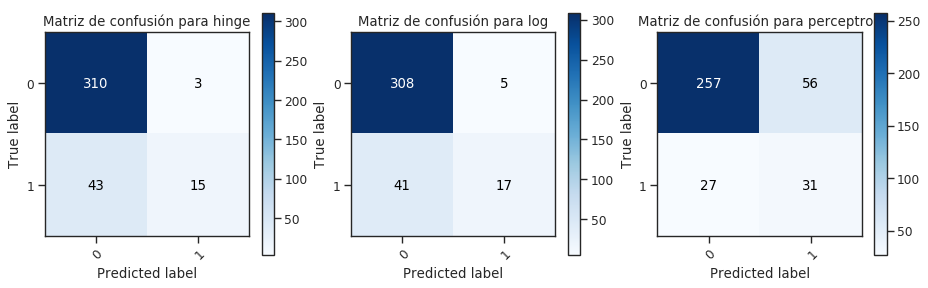

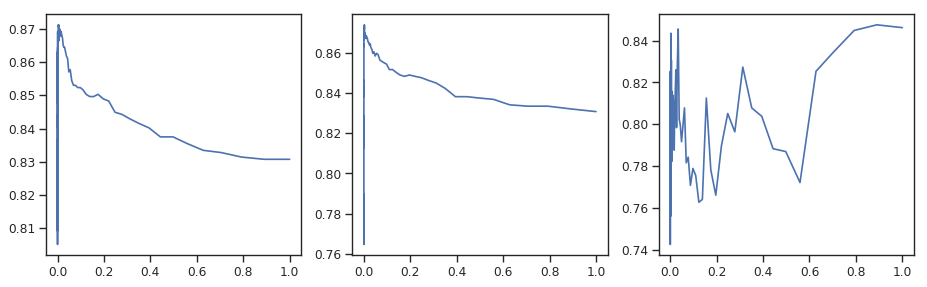

In [28]:
f1, ax1 = plt.subplots(1,3,figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
f2, ax2 = plt.subplots(1,3,figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

alpha = np.logspace(0,-5,100)
learning_rate = 'optimal'

for idx, loss in enumerate(('hinge','log','perceptron'), start=0):
    exploring_params = {
        'alpha': alpha  # Tasa de regularización
    }
    m = linear_model.SGDClassifier(random_state=617,loss=loss,tol=1e-3,eta0=0.0,learning_rate=learning_rate)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    accu = np.zeros(len(alpha),dtype=np.float)
    _x = np.zeros(len(alpha),dtype=np.float)
    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for i, (mean, std, params) in enumerate(zip(means,stds,model.cv_results_['params'])):
        _x[i] = params['alpha']
        accu[i] = means[i]
        print("Exactitud: %0.3f (+/- %0.03e) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")

    plot_confusion_matrix(y_true, y_pred,classes=dataset.TARGET.unique(), 
                          ax=ax1[idx],title="Matriz de confusión para %s" % loss)
    
    sns.lineplot(_x,accu,ax=ax2[idx])


In [34]:
alpha = np.logspace(-2,-4,200)

param_grid = {
    'loss': ['log'], #función de loss
    'learning_rate': ['optimal'],
    'alpha': alpha  # Tasa de regularización
}

Mejor conjunto de parámetros:
{'alpha': 0.0023272024789604095, 'learning_rate': 'optimal', 'loss': 'log'}

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       313
           1       0.76      0.28      0.41        58

   micro avg       0.87      0.87      0.87       371
   macro avg       0.82      0.63      0.67       371
weighted avg       0.86      0.87      0.85       371





[]

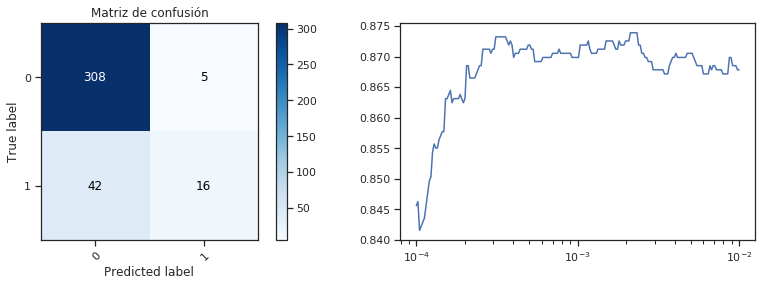

In [35]:
m = linear_model.SGDClassifier(random_state=617,tol=1e-3)
model = GridSearchCV(m, param_grid, cv=5, scoring='accuracy',n_jobs=4)
model.fit(X_train, y_train)
    
print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

accu = np.zeros(len(alpha),dtype=np.float)
_x = np.zeros(len(alpha),dtype=np.float)
means = model.cv_results_['mean_test_score']
for i, params in enumerate(model.cv_results_['params']):
    _x[i] = params['alpha']
    accu[i] = means[i]
    
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")
print("================================================", end="\n\n")

f, ax = plt.subplots(1,2,figsize=(14,4))

plot_confusion_matrix(y_true, y_pred,classes=dataset.TARGET.unique(),ax=ax[0], title="Matriz de confusión" )

sns.lineplot(_x,accu,ax=ax[1])
plt.semilogx()

## Ejercicio 3: Árbol de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [36]:
from sklearn import tree

In [38]:
clf = tree.DecisionTreeClassifier(random_state=617)
clf = clf.fit(X_train, y_train)

In [39]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       313
           1       0.68      0.67      0.68        58

   micro avg       0.90      0.90      0.90       371
   macro avg       0.81      0.81      0.81       371
weighted avg       0.90      0.90      0.90       371




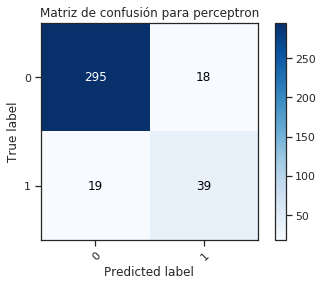

In [42]:
plot_confusion_matrix(y_true, y_pred,
                      classes=dataset.TARGET.unique(), title="Matriz de confusión para %s" % loss)

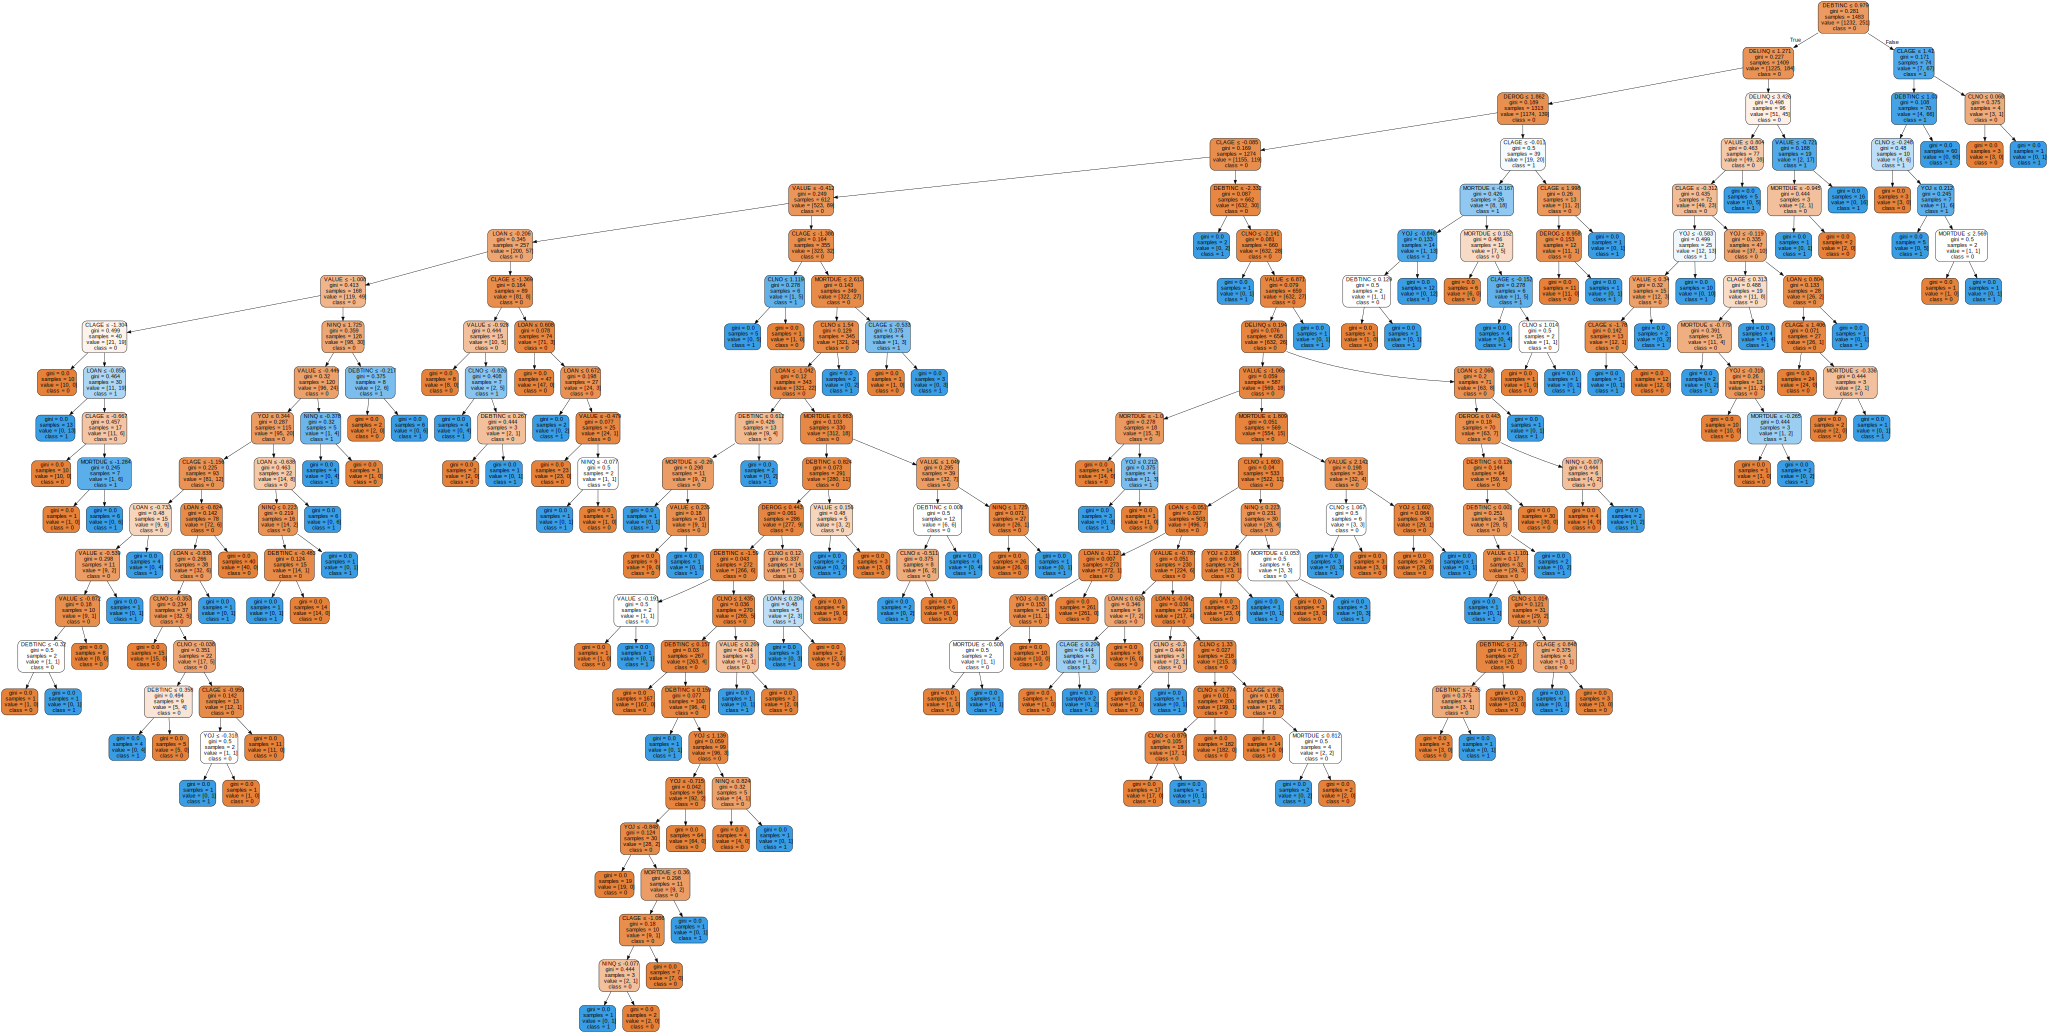

In [43]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=dataset.columns[1:],  
                      class_names=["0","1"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Exploración de hiperparámetros para función de coste "gini"

Mejor conjunto de parámetros:
{'max_depth': 14, 'min_samples_leaf': 1, 'splitter': 'random'}

Puntajes de la grilla:

Exactitud: 0.874 (+/-0.001) para los parámetros {'max_depth': 12, 'min_samples_leaf': 1, 'splitter': 'best'}
Exactitud: 0.881 (+/-0.000) para los parámetros {'max_depth': 12, 'min_samples_leaf': 1, 'splitter': 'random'}
Exactitud: 0.871 (+/-0.000) para los parámetros {'max_depth': 12, 'min_samples_leaf': 2, 'splitter': 'best'}
Exactitud: 0.877 (+/-0.000) para los parámetros {'max_depth': 12, 'min_samples_leaf': 2, 'splitter': 'random'}
Exactitud: 0.871 (+/-0.001) para los parámetros {'max_depth': 13, 'min_samples_leaf': 1, 'splitter': 'best'}
Exactitud: 0.878 (+/-0.000) para los parámetros {'max_depth': 13, 'min_samples_leaf': 1, 'splitter': 'random'}
Exactitud: 0.870 (+/-0.000) para los parámetros {'max_depth': 13, 'min_samples_leaf': 2, 'splitter': 'best'}
Exactitud: 0.881 (+/-0.000) para los parámetros {'

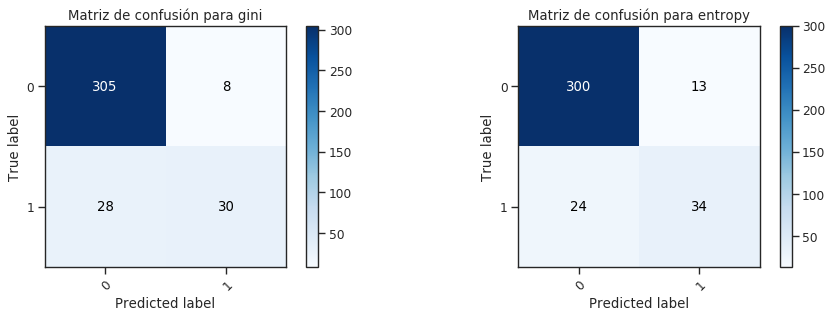

In [49]:
f, ax = plt.subplots(1,2,figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

criterions = ['gini','entropy']
splitter = ["best","random"]
max_depth = np.arange(12,16)
min_samples_leaf = np.arange(1,3)

for idx, criterion in enumerate(criterions, start=0):
    exploring_params = {
        'max_depth': max_depth,  # Profundidad máxima del árbol
        'min_samples_leaf': min_samples_leaf,  # Cantidad mínima de samples por hoja
        'splitter': splitter
    }
    
    m = tree.DecisionTreeClassifier(random_state=617,criterion=criterion)
    model = GridSearchCV(m, exploring_params, scoring='accuracy',cv=5)
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % criterion, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")

    plot_confusion_matrix(y_true, y_pred,ax=ax[idx],
                          classes=dataset.TARGET.unique(), title="Matriz de confusión para %s" % criterion)